In [1]:
import sys
sys.version

'3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]'

In [2]:
from qiskit import Aer, ClassicalRegister, QuantumCircuit, QuantumRegister, execute
from qiskit.circuit.library.standard_gates import XGate, ZGate
#initialization
import matplotlib.pyplot as plt
import numpy as np
# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_paulivec

In [3]:
# Get backend
backend = Aer.get_backend("qasm_simulator")
statevector = Aer.get_backend("statevector_simulator")

In [4]:
a = QuantumRegister(1)
cq = QuantumRegister(2)
c = ClassicalRegister(3)
qc = QuantumCircuit(a, cq, c)

qc.h(a)
qc.h(cq)

In [5]:
def mult(a, b):
    aq = QuantumRegister(a)
    bq = QuantumRegister(b)
    cq = QuantumRegister(a + b)
    anc = QuantumRegister(1)

    qc = QuantumCircuit(aq, bq, cq, anc, name="Mult(%i, %i)" % (a, b))

    for _ in range(pow(2, b)):
        qc.append(qor(b), bq[:] + [anc])
        qc.append(sum(a+b, a).to_gate().control(1), [anc] + cq[:] + aq[:])
        qc.append(sub(1, b).to_gate().control(1), [anc] + bq[:])
        qc.reset(anc)

    return qc

In [6]:
def sum(a, b):

    ''' Sums a + b on a register, if it can't handle it will overflow'''
    aq = QuantumRegister(a)
    bq = QuantumRegister(b)

    qc = QuantumCircuit(aq, bq, name="Sum(%i, %i)" % (a, b))

    for i in range(b):
        for j in reversed(range(i, a)):
            qc.mct(aq[i:j] + [bq[i]], aq[j], None, mode='advanced')

    return qc

In [7]:
def bitfield(n):
    return [int(digit) for digit in bin(n)[2:]] # [2:]

In [8]:
def add(k, n):
    ''' Generates a quantum circuit that adds k to n qubits where represents q[0] the less significant qubit'''
    q = QuantumRegister(n)
    qc = QuantumCircuit(q, name='Add(%i)' % k)

    bits = bitfield(k)[::-1]
    for i in range(len(bits)):
        if bits[i]:
            for k in reversed(range(i, len(bits))):
                qc.mct(q[i:k], q[k], None, mode='advanced')
            #qc.x(q[i])

    return qc

In [9]:
def sub(k, n):
    ''' Generates a quantum cirucuit that substracts k to n qubits where q[0] represents the less significant qubit'''  
    return add(2**n - k, n)

In [10]:
def qor(n=2):
    q = QuantumRegister(n)
    a = QuantumRegister(1)
    qc = QuantumCircuit(q, a, name="Or(%i)" % n)
    
    qc.x(q)
    qc.append(XGate().control(n), q[:] + [a])
    qc.x(q)
    qc.x(a)

    return qc


In [11]:
# Oracle
oq = QuantumRegister(2)
O = QuantumCircuit(oq, name="Oracle")
O.x(oq[0])
O.append(ZGate().control(1), oq[:])
O.x(oq[0])

In [12]:
# Diffusor
d = QuantumRegister(2)
Dif = QuantumCircuit(d, name="Diffusor")
Dif.x(d)
Dif.h(d)
Dif.append(ZGate().control(1), d[:])
Dif.x(d)
Dif.h(d)

In [13]:
qc.append(sum(1, 2), a[:] + cq[:])

In [14]:
N = 1
for _ in range(N):
    qc.append(O, cq)
    qc.append(Dif, cq[:])

In [15]:
job = execute(qc, statevector)

In [16]:
qc.measure(cq, c[:2])
qc.measure(a, c[2:])

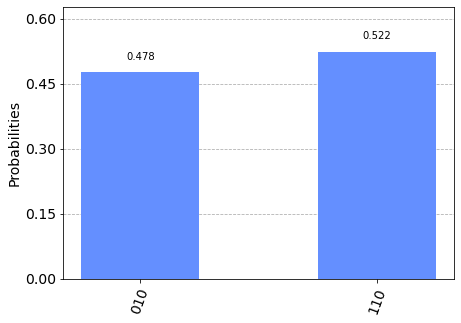

In [17]:
jobc = execute(qc, backend, shots=1024)
st = job.result().get_statevector()
counts = jobc.result().get_counts()

plot_histogram(counts)


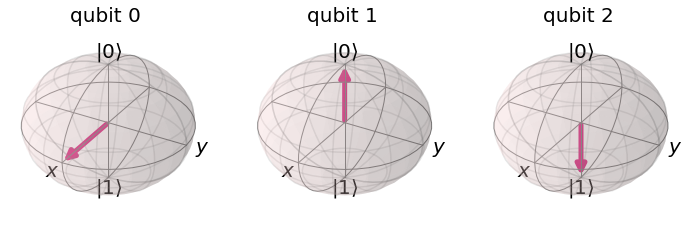

In [18]:
plot_bloch_multivector(st)

In [19]:
qc.draw()

┌───┐┌────────────┐           ┌─┐                   
q0_0: ┤ H ├┤0           ├───────────┤M├───────────────────
      ├───┤│            │┌─────────┐└╥┘┌───────────┐┌─┐   
q1_0: ┤ H ├┤1 Sum(1, 2) ├┤0        ├─╫─┤0          ├┤M├───
      ├───┤│            ││  Oracle │ ║ │  Diffusor │└╥┘┌─┐
q1_1: ┤ H ├┤2           ├┤1        ├─╫─┤1          ├─╫─┤M├
      └───┘└────────────┘└─────────┘ ║ └───────────┘ ║ └╥┘
c0_0: ═══════════════════════════════╬═══════════════╩══╬═
                                     ║                  ║ 
c0_1: ═══════════════════════════════╬══════════════════╩═
                                     ║                    
c0_2: ═══════════════════════════════╩════════════════════